In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-4/Data-dictionary.xlsx
/kaggle/input/data-storm-4/DataStorm4.0_KaggleProblemStatement.pdf
/kaggle/input/data-storm-4/Store-info.csv
/kaggle/input/data-storm-4/Testing-data.csv
/kaggle/input/data-storm-4/Historical-transaction-data.csv


In [2]:
from sklearn.preprocessing import LabelEncoder

df_store = pd.read_csv('/kaggle/input/data-storm-4/Store-info.csv')
df_test = pd.read_csv('/kaggle/input/data-storm-4/Testing-data.csv')
df_transac = pd.read_csv('/kaggle/input/data-storm-4/Historical-transaction-data.csv')

merged_df_test = pd.merge(df_transac, df_store[['shop_id', 'shop_area_sq_ft', 'shop_profile']], on='shop_id')
merged_df_test = merged_df_test.drop(columns = ['invoice_id', 'item_description'])

In [3]:
merged_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473974 entries, 0 to 473973
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   transaction_date  473974 non-null  object
 1   customer_id       473974 non-null  object
 2   shop_id           473974 non-null  object
 3   item_price        473974 non-null  int64 
 4   quantity_sold     473974 non-null  int64 
 5   shop_area_sq_ft   473974 non-null  int64 
 6   shop_profile      387341 non-null  object
dtypes: int64(3), object(4)
memory usage: 28.9+ MB


In [4]:
median_quantity_sold = merged_df_test[merged_df_test['quantity_sold'] > 0]['quantity_sold'].median()

merged_df_test['quantity_sold'] = merged_df_test['quantity_sold'].apply(lambda x: median_quantity_sold if x <= 0 else x)

In [5]:
merged_df_test['revenue'] = merged_df_test['item_price'] * merged_df_test['quantity_sold']
total_revenue_per_store = merged_df_test.groupby('shop_id')['revenue'].sum().reset_index()

total_revenue_per_store.head(84)

,shop_id,revenue
0,SHOP001,1500655.0
1,SHOP002,3111825.0
2,SHOP003,1942645.0
3,SHOP004,1593650.0
4,SHOP005,2168730.0
...,...,...
79,SHOP081,2085310.0
80,SHOP082,2732445.0
81,SHOP083,1712685.0
82,SHOP084,2962040.0


In [6]:
merged_df_test['transaction_date'] = pd.to_datetime(merged_df_test['transaction_date'])

merged_df_test['day_of_week'] = merged_df_test['transaction_date'].dt.dayofweek
merged_df_test['month'] = merged_df_test['transaction_date'].dt.month
merged_df_test['year'] = merged_df_test['transaction_date'].dt.year

monthly_sales = merged_df_test.groupby(['shop_id', 'month'])['quantity_sold'].sum().reset_index()
monthly_sales.columns = ['shop_id', 'month', 'monthly_total_sales']

In [7]:
monthly_sales.head()

,shop_id,month,monthly_total_sales
0,SHOP001,10,1129.0
1,SHOP001,11,1514.0
2,SHOP001,12,1379.0
3,SHOP002,10,2608.0
4,SHOP002,11,3979.0


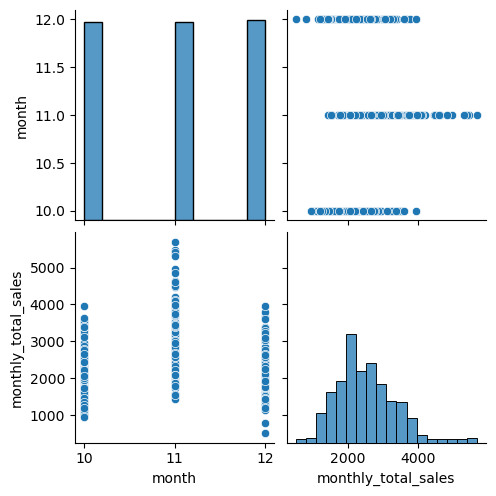

In [8]:
import seaborn as sns

sns.pairplot(monthly_sales)

In [9]:
merged_df_test.head()

,transaction_date,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,revenue,day_of_week,month,year
0,2021-12-11 00:00:00+00:00,BGXA,SHOP008,220,2.0,678,Moderate,440.0,5,12,2021
1,2021-12-13 00:00:00+00:00,VN7V,SHOP008,160,2.0,678,Moderate,320.0,0,12,2021
2,2021-12-13 00:00:00+00:00,VN7V,SHOP008,150,2.0,678,Moderate,300.0,0,12,2021
3,2021-12-10 00:00:00+00:00,VT9C,SHOP008,220,1.0,678,Moderate,220.0,4,12,2021
4,2021-12-10 00:00:00+00:00,8QLS,SHOP008,440,1.0,678,Moderate,440.0,4,12,2021


In [10]:
unique_customers_per_shop = merged_df_test.groupby('shop_id')['customer_id'].nunique().reset_index()
unique_customers_per_shop.columns = ['shop_id', 'unique_customers']

unique_customers_per_shop.head()

,shop_id,unique_customers
0,SHOP001,1118
1,SHOP002,2577
2,SHOP003,2064
3,SHOP004,1744
4,SHOP005,2203


In [11]:
df_store_new = pd.merge(df_store, total_revenue_per_store[['shop_id', 'revenue']], on='shop_id')
df_store_new = pd.merge(df_store_new, unique_customers_per_shop[['shop_id', 'unique_customers']], on='shop_id')

df_store_new.head()

,shop_id,shop_area_sq_ft,shop_profile,revenue,unique_customers
0,SHOP047,528,Moderate,851850.0,928
1,SHOP009,676,High,1994030.0,2498
2,SHOP083,676,Low,1712685.0,1900
3,SHOP117,676,Low,2344760.0,2037
4,SHOP042,676,Low,1357965.0,1841


In [12]:
df_store_train = df_store_new.head(100)
df_store_test = df_store_new.tail(24)

In [13]:
df_y = pd.DataFrame(df_store_train['shop_profile'])
df_store_train = df_store_train.drop(columns = ['shop_profile'])
df_y_pred = df_store_test.drop(columns = ['shop_profile'])

In [14]:
from sklearn.model_selection import train_test_split

X = df_store_train.drop('shop_profile', axis=1)
y = df_store_train['shop_profile']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KeyError: "['shop_profile'] not found in axis"

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [ ]:
df_test.head(100)

In [ ]:
le = LabelEncoder()
# le2 = LabelEncoder()

df_store_train['shop_id'] = le.fit_transform(df_store_train['shop_id'])
df_y_pred['shop_id'] = le.fit_transform(df_y_pred['shop_id'])
df_y['shop_profile'] = le.fit_transform(df_y['shop_profile'])

df_store_train['shop_id'] = df_store_train['shop_id'].astype(int)
df_y_pred['shop_id'] = df_y_pred['shop_id'].astype(int)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
    
knn = KNeighborsClassifier(n_neighbors=13)

df = np.array(df_y)

knn.fit(df_store_train, df.ravel())

y_pred = knn.predict(df_y_pred)

df_test = df_test.drop(columns = ['shop_profile'])

df_test['shop_profile'] = pd.DataFrame(y_pred)

df_test['shop_profile'] = le.inverse_transform(df_test['shop_profile'])

df_test.head()

df_test.to_csv("predictions.csv", index=False)

In [ ]:
le = LabelEncoder()

y_test['shop_profile'] = le.fit_transform(y_test['shop_profile'])
y_train['shop_profile'] = le.fit_transform(y_train['shop_profile'])
X_train['shop_id'] = le.fit_transform(X_train['shop_id'])
X_test['shop_id'] = le.fit_transform(X_test['shop_id'])

X_train['shop_id'] = X_train['shop_id'].astype(int)
X_test['shop_id'] = X_test['shop_id'].astype(int)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
    
knn = KNeighborsClassifier(n_neighbors=13)

df = np.array(y_train)

knn.fit(X_train, df.ravel())

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy:", accuracy, "%")

**Earlier Edits**

In [ ]:
merged_df = pd.merge(df_transac, df_store[['shop_id', 'shop_area_sq_ft', 'shop_profile']], on='shop_id')

mask = merged_df['shop_profile'].isnull()

test_df = merged_df[mask]

In [ ]:
df_y = pd.DataFrame(merged_df['shop_profile'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

merged_df['shop_id'] = le.fit_transform(merged_df['shop_id'])

df_transac2 = merged_df.drop(columns=['invoice_id','customer_id','transaction_date','item_description'])